In [1]:
import pandas as pd
import os
import ast
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, roc_curve
)
from sklearn.model_selection import train_test_split, ParameterSampler
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import datetime
import random
from tqdm import tqdm
import gc

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir = '/dir_to_datasets'

In [15]:
dataset_paths = {
    'squad': {
        'train': os.path.join(dir, 'squad_df_train.csv'), # 7900 examples
        'val': os.path.join(dir, 'squad_df_val.csv'), # 1000 examples
        'test': os.path.join(dir, 'squad_df_test.csv'), # 1000 examples
        'sample_sizes': [3950] # [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600,
    },
    'nq': {
        'train': os.path.join(dir, 'nq_df_train.csv'), # 7900 examples
        'val': os.path.join(dir, 'nq_df_val.csv'), # 1000 examples
        'test': os.path.join(dir, 'nq_df_test.csv'), # 1000 examples
        'sample_sizes': [400, 800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 3950]
    },
    'defan': {
        'train': os.path.join(dir, 'defan_df_train.csv'), # 29776 examples
        'val': os.path.join(dir, 'defan_df_val.csv'), # 8559 examples
        'test': os.path.join(dir, 'defan_df_test.csv'), # 4269 examples
        'sample_sizes': [400, 800, 3950, 10000, 20000]
    },
    'combined': {
        'train': os.path.join(dir, 'combined_df_train.csv'),
        'val': os.path.join(dir, 'combined_df_val.csv'),
        'test': os.path.join(dir, 'combined_df_test.csv'),
        'sample_sizes': [400, 800, 1200, 2000, 4000, 8000, 11850]
    }
}

In [6]:
def extract_values(list_of_dicts):
    all_values = []
    for attr_dict in list_of_dicts:
        values = []
        for k, v in attr_dict.items():
            if k != "index":
                values.append(v)
        all_values.append(values)
    return all_values



def pad_attrib(attrib, max_input_len, max_output_len):
    np_attrib = np.array(attrib)
    if np_attrib.shape[0] >= max_input_len:
        np_attrib = np_attrib[:max_input_len]
    if np_attrib.shape[1] >= max_output_len:
        np_attrib = np_attrib[:, :max_output_len]

    np_attrib = np.pad(np_attrib, ((0, max_input_len - np_attrib.shape[0]), (0, max_output_len - np_attrib.shape[1])), mode='constant')
    return np_attrib


def preprocess_data(df, max_input_len=None, max_output_len=None, method='prob_diff'):
    attributions_full = df["attributions_full"].apply(ast.literal_eval)

    method_ix = 1 if method == 'prob_diff' else 0
    df[f"{method}_sequence"] = attributions_full.apply(lambda x: extract_values(x[method_ix]["data"]))

    le = LabelEncoder()
    df["verdict_label"] = le.fit_transform(df["verdict"])

    if max_input_len is not None:
        sample_input_len = max_input_len
        sample_output_len = max_output_len
    # else:
    #     sample_input_len = df[f"{method}_sequence"].apply(len).max()
    #     sample_output_len = df[f"{method}_sequence"].apply(lambda x: len(x[0])).max()
    else:
        max_input = df[f"{method}_sequence"].apply(len).max()
        sample_input_len = int(np.percentile(df[f"{method}_sequence"].apply(lambda x: len(x[0])), 98 ))
        ninenine_i = int(np.percentile(df[f"{method}_sequence"].apply(lambda x: len(x[0])), 99 ))
        print(f">> Percentile 98: {sample_input_len}")
        print(f">> Percentile 99: {ninenine_i}")
        print(f">> Maxx input: {max_input}")

        max_output = df[f"{method}_sequence"].apply(lambda x: len(x[0])).max()
        sample_output_len = int(np.percentile(df[f"{method}_sequence"].apply(lambda x: len(x[0])), 98 ))
        ninenine_o = int(np.percentile(df[f"{method}_sequence"].apply(lambda x: len(x[0])), 99 ))
        print(f">> Percentile 98: {sample_output_len}")
        print(f">> Percentile 99: {ninenine_o}")
        print(f">> Maxx output: {max_output}")

    sequence_padded = np.array(
        df[f"{method}_sequence"].apply(lambda x: pad_attrib(x, sample_input_len, sample_output_len))
    )

    df[f'{method}_sequence_padded'] = sequence_padded.tolist()


    df[f"{method}_mean"] = df[f"{method}_sequence"].apply(np.mean)
    df[f"{method}_std"] = df[f"{method}_sequence"].apply(np.std)
    df[f"{method}_max"] = df[f"{method}_sequence"].apply(np.max)
    df[f"{method}_min"] = df[f"{method}_sequence"].apply(np.min)
    df[f"{method}_median"] = df[f"{method}_sequence"].apply(np.median)
    df[f"{method}_q25"] = df[f"{method}_sequence"].apply(lambda x: np.percentile(x, 25))
    df[f"{method}_q75"] = df[f"{method}_sequence"].apply(lambda x: np.percentile(x, 75))

    return df, sample_input_len, sample_output_len

In [7]:
class HallucinationDataset(Dataset):
    def __init__(self, df, X_column, y_column):
        self.sequences = df[X_column].tolist()
        self.labels = df[y_column].values

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = np.array(self.sequences[idx], dtype=np.float32)
        sequence = torch.tensor(sequence)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence, label

In [8]:
class SimpleNN(nn.Module):
    def __init__(self, input_shape, output_shape, breadth, depth, dropout, interpolate=True):
        super(SimpleNN, self).__init__()

        self.layers = []

        self.layers.append(nn.Linear(input_shape, breadth))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(dropout))

        if interpolate:
            change_rate = int((breadth - output_shape) / max(1, depth))
            layer_sizes = [breadth - change_rate * i for i in range(depth)]

            for l in layer_sizes[:-1]:
                self.layers.append(nn.Linear(l, l - change_rate))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout))

            self.layers.append(nn.Linear(layer_sizes[-1], output_shape))

        else:
            for _ in range(depth - 1):
                self.layers.append(nn.Linear(breadth, breadth))
                self.layers.append(nn.ReLU())
                self.layers.append(nn.Dropout(dropout))
            self.layers.append(nn.Linear(breadth, output_shape))

        self.layers = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.layers(x.reshape(x.size(0), -1))

In [9]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=20, log_freq=1, device='cpu', patience=6):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    best_val_loss = float('inf')
    early_stopping_counter = 0

    best_model_state = None
    best_epoch = 0
    best_metrics = {}

    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}

    total_samples = sum(len(batch[0]) for batch in train_loader)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for sequences, labels in train_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        history['train_loss'].append(avg_train_loss)
        history['train_accuracy'].append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []
        all_probs = []

        with torch.no_grad():
            for sequences, labels in val_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                probs = torch.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)

        scheduler.step(avg_val_loss)

        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)
        val_precision = precision_score(all_labels, all_preds, average="weighted")
        val_recall = recall_score(all_labels, all_preds, average="weighted")
        val_f1 = f1_score(all_labels, all_preds, average="weighted")
        n_classes = all_probs.shape[1]
        if n_classes == 2:
            val_auroc = roc_auc_score(all_labels, all_probs[:, 1])
        else:
            binary_labels = label_binarize(all_labels, classes=range(n_classes))
            val_auroc = roc_auc_score(binary_labels, all_probs, average="macro", multi_class="ovr")

        if (epoch + 1) % log_freq == 0:
            print(
                f"Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {avg_train_loss:.4f}, Train Acc: {100 * train_accuracy:.2f}%, "
                f"Val Loss: {avg_val_loss:.4f}, Val Acc: {100 * val_accuracy:.2f}%, "
                f"Val F1: {val_f1:.4f}, Val AUROC: {val_auroc:.4f}"
            )

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            best_epoch = epoch
            best_metrics = {
                'val_loss': avg_val_loss,
                'val_accuracy': val_accuracy,
                'val_precision': val_precision,
                'val_recall': val_recall,
                'val_f1': val_f1,
                'val_auroc': val_auroc
            }
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

    model.load_state_dict(best_model_state)

    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Learning Curve (Total Samples: {total_samples})')
    plt.legend()
    plt.show()

    return model, best_metrics, best_epoch, history

In [11]:
def evaluate_model(model, data_loader, device="cpu"):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    cm = confusion_matrix(all_labels, all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    n_classes = all_probs.shape[1]
    if n_classes == 2:
        auroc = roc_auc_score(all_labels, all_probs[:, 1])
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs[:, 1])
    else:
        binary_labels = label_binarize(all_labels, classes=range(n_classes))
        auroc = roc_auc_score(binary_labels, all_probs, average="macro", multi_class="ovr")
        fpr = dict()
        tpr = dict()
        thresholds = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], thresholds[i] = roc_curve(binary_labels[:, i], all_probs[:, i])

    metrics = {
        "confusion_matrix": cm,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "num_classes": n_classes,
        "auroc": auroc,
        "fpr": fpr,
        "tpr": tpr,
        "thresholds": thresholds
    }

    return metrics

# Models Training and Evaluation on Test sets

In [28]:
def build_classifiers(dataset_paths, model_class, preprocess_data, HallucinationDataset, train_model, save_dir, method, sample_size=None):
    classifiers = {}
    max_input_len = 0
    max_output_len = 0

    params = {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.6, 'batch_size': 128}

    print("Determining max lengths")
    for dataset_name, paths in tqdm(dataset_paths.items()):
        try:
            print(f"Processing {dataset_name} for max length determination")
            train_df = pd.read_csv(paths['train'])
            train_df, input_len, output_len = preprocess_data(train_df, method=method)
            max_input_len = max(max_input_len, input_len)
            max_output_len = max(max_output_len, output_len)
        except Exception as e:
            print(f"Error processing {dataset_name}: {e}")
        finally:
            del train_df
            gc.collect()

    print(f"Max input length: {max_input_len}, Max output length: {max_output_len}")

    print("Building and training classifiers")
    for dataset_name, paths in tqdm(dataset_paths.items()):
        print(f"Building classifier for {dataset_name}")

        print("Loading and preprocessing training data")
        train_df = pd.read_csv(paths['train'])
        train_df, _, _ = preprocess_data(train_df, max_input_len, max_output_len, method=method)

        if sample_size:
            if sample_size == '400':
                target_size = 400
            elif sample_size == '8k':
                target_size = 7900
            elif sample_size == '10k':
                target_size = 10000
            else:
                raise ValueError("Invalid sample_size. Use '400', '8k' or '10k'.")

            if len(train_df) >= target_size:
                print(f"Sampling training data to {target_size} examples")
                hallucination_samples = train_df[train_df['verdict'] == 'Hallucination'].sample(target_size // 2, random_state=42)
                correct_samples = train_df[train_df['verdict'] == 'Correct'].sample(target_size // 2, random_state=42)
                train_df = pd.concat([hallucination_samples, correct_samples]).sample(frac=1, random_state=42).reset_index(drop=True)
            else:
                print(f"Skipping sampling as train_df size ({len(train_df)}) is not larger than {target_size}")

        print("Loading and preprocessing validation data")
        val_df = pd.read_csv(paths['val'])
        val_df, _, _ = preprocess_data(val_df, max_input_len, max_output_len, method=method)

        print("Creating datasets and dataloaders")
        train_dataset = HallucinationDataset(train_df, f'{method}_sequence_padded', 'verdict_label')
        val_dataset = HallucinationDataset(val_df, f'{method}_sequence_padded', 'verdict_label')
        train_loader = DataLoader(train_dataset, params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, params['batch_size'], shuffle=False)

        del train_df, val_df
        gc.collect()

        print("Initializing model")
        input_shape = train_dataset[0][0].reshape(-1).shape[0]
        output_shape = len(set(train_dataset.labels))
        model = model_class(
            input_shape=input_shape,
            output_shape=output_shape,
            breadth=params['hidden_size'],
            depth=params['num_layers'],
            dropout=params['dropout']
        ).to(device)

        print("Training model")
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=1e-5)
        trained_model, best_metrics, best_epoch, _ = train_model(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            epochs=100,
            device=device,
            patience=6
        )

        print("Saving model")
        model_save_path = os.path.join(save_dir, f"{dataset_name}_{method}_{sample_size}_model.pth")
        torch.save(trained_model.state_dict(), model_save_path)

        classifiers[f"{dataset_name}_{method}_{sample_size}"] = {
            'model': trained_model,
            'best_metrics': best_metrics,
            'best_epoch': best_epoch
        }

        del train_dataset, val_dataset, train_loader, val_loader
        gc.collect()
        torch.cuda.empty_cache()

    return classifiers, max_input_len, max_output_len


def evaluate_classifiers(classifiers, dataset_paths, preprocess_data, HallucinationDataset, evaluate_model, save_dir, method, max_input_len, max_output_len):
    # params = {'num_layers': 2, 'learning_rate': 0.005, 'hidden_size': 128, 'dropout': 0.75, 'batch_size': 128}
    params = {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.6, 'batch_size': 128}

    print("Evaluating classifiers")
    for trained_on, classifier_info in classifiers.items():
        model = classifier_info['model']

        print(f"> Evaluating {trained_on}")
        for evaluated_on, paths in tqdm(dataset_paths.items()):
            print(f"Evaluating model trained on {trained_on} dataset on {evaluated_on} dataset")

            print("Loading and preprocessing test data")
            test_df = pd.read_csv(paths['test'])
            test_df, _, _ = preprocess_data(test_df, max_input_len, max_output_len, method=method)

            print("Creating dataset and dataloader")
            test_dataset = HallucinationDataset(test_df, f'{method}_sequence_padded', 'verdict_label')
            test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

            del test_df
            gc.collect()

            print("Evaluating model")
            metrics = evaluate_model(model, test_loader, device)

            results_dir = os.path.join(save_dir, 'data', f"trained_{trained_on}_evaluated_{evaluated_on}")
            os.makedirs(results_dir, exist_ok=True)

            with open(os.path.join(results_dir, 'metrics.txt'), 'w') as f:
                for metric, value in metrics.items():
                    if isinstance(value, (int, float)):
                        f.write(f"{metric}: {value}\n")

            print("Plotting confusion matrix")
            plt.figure(figsize=(10, 8))
            plt.imshow(metrics['confusion_matrix'], interpolation='nearest', cmap=plt.cm.Blues)
            plt.title(f"Confusion Matrix - Trained on {trained_on}, Evaluated on {evaluated_on}")
            plt.colorbar()
            plt.tight_layout()
            plt.savefig(os.path.join(results_dir, f"trained_{trained_on}_evaluated_{evaluated_on}_confusion_matrix.png"))
            plt.close()

            print("Plotting ROC curve")
            plt.figure(figsize=(10, 8))
            if metrics['num_classes'] == 2:
                plt.plot(metrics['fpr'], metrics['tpr'], label=f'ROC curve (AUC = {metrics["auroc"]:.2f})')
            else:
                for i in range(metrics['num_classes']):
                    plt.plot(metrics['fpr'][i], metrics['tpr'][i], label=f'ROC curve of class {i} (AUC = {auc(metrics["fpr"][i], metrics["tpr"][i]):.2f})')

            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - Trained on {trained_on}, Evaluated on {evaluated_on}')
            plt.legend(loc="lower right")
            plt.savefig(os.path.join(results_dir, f"{method}_trained_{trained_on}_evaluated_{evaluated_on}_roc_curve.png"))
            plt.close()

            del test_dataset, test_loader
            gc.collect()
            torch.cuda.empty_cache()

    print("Evaluation completed. Results saved in the data folder.")

# Using ProbDiff


Created save directory: /content/drive/MyDrive/arb/pizza/pizza-dataset-files/nature_datasets_FINAL/final_datasets/model_checkpoints_FINAL_v3_DUO
Determining max lengths


  0%|          | 0/1 [00:00<?, ?it/s]

Processing squad for max length determination
>> Percentile 98: 100
>> Percentile 99: 116
>> Maxx input: 44
>> Percentile 98: 100
>> Percentile 99: 116
>> Maxx output: 1224


100%|██████████| 1/1 [01:21<00:00, 81.49s/it]


Max input length: 100, Max output length: 100
Building and training classifiers


  0%|          | 0/1 [00:00<?, ?it/s]

Building classifier for squad
Loading and preprocessing training data
Sampling training data to 7900 examples
Loading and preprocessing validation data
Creating datasets and dataloaders
Initializing model
Training model


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.6925, Train Acc: 51.94%, Val Loss: 0.6859, Val Acc: 55.40%, Val F1: 0.5105, Val AUROC: 0.6120
Epoch 2/100, Train Loss: 0.6873, Train Acc: 54.56%, Val Loss: 0.6831, Val Acc: 56.70%, Val F1: 0.5670, Val AUROC: 0.6016
Epoch 3/100, Train Loss: 0.6867, Train Acc: 56.28%, Val Loss: 0.6815, Val Acc: 56.40%, Val F1: 0.5339, Val AUROC: 0.6044
Epoch 4/100, Train Loss: 0.6826, Train Acc: 57.04%, Val Loss: 0.6748, Val Acc: 59.00%, Val F1: 0.5795, Val AUROC: 0.6341
Epoch 5/100, Train Loss: 0.6795, Train Acc: 57.86%, Val Loss: 0.6760, Val Acc: 58.10%, Val F1: 0.5756, Val AUROC: 0.6235
Epoch 6/100, Train Loss: 0.6793, Train Acc: 58.28%, Val Loss: 0.6734, Val Acc: 58.10%, Val F1: 0.5792, Val AUROC: 0.6230
Epoch 7/100, Train Loss: 0.6770, Train Acc: 58.03%, Val Loss: 0.6681, Val Acc: 60.10%, Val F1: 0.6007, Val AUROC: 0.6413
Epoch 8/100, Train Loss: 0.6784, Train Acc: 57.35%, Val Loss: 0.6759, Val Acc: 58.20%, Val F1: 0.5713, Val AUROC: 0.6330
Epoch 9/100, Train Loss: 0.6775,

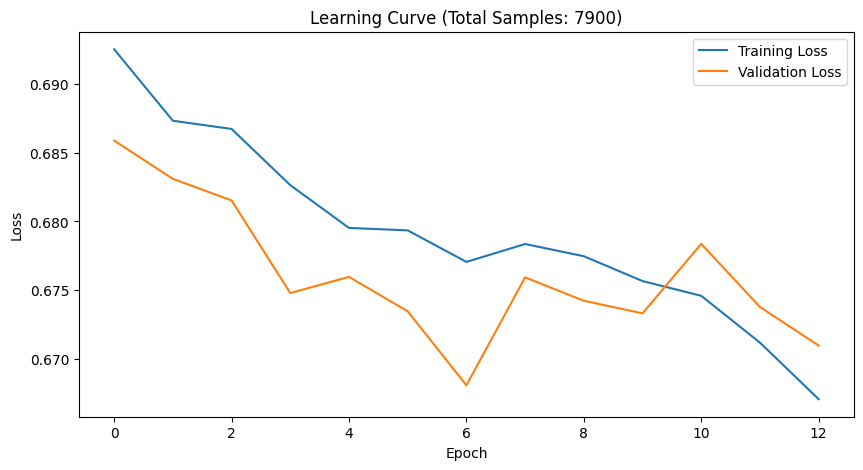

Saving model


100%|██████████| 1/1 [01:42<00:00, 102.85s/it]


Evaluating classifiers
> Evaluating squad_prob_diff_8k


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating model trained on squad_prob_diff_8k dataset on squad dataset
Loading and preprocessing test data
Creating dataset and dataloader
Evaluating model
Plotting confusion matrix
Plotting ROC curve


100%|██████████| 1/1 [00:12<00:00, 12.58s/it]

Evaluation completed. Results saved in the data folder.


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_folder = "model_checkpoints_FINAL_v3_DUO"
method = 'prob_diff'
save_dir = os.path.join(dir, save_folder)
os.makedirs(save_dir, exist_ok=True)
print(f"Created save directory: {save_dir}")

# Build and train classifiers
classifiers, max_input_len, max_output_len = build_classifiers(
    dataset_paths,
    SimpleNN,
    preprocess_data,
    HallucinationDataset,
    train_model,
    save_dir,
    method,
    sample_size='8k' # 400, 8k, 10k
)

# Evaluate classifiers
evaluate_classifiers(
    classifiers,
    dataset_paths,
    preprocess_data,
    HallucinationDataset,
    evaluate_model,
    save_dir,
    method,
    max_input_len,
    max_output_len
)

# Using Cosine

Created save directory: /content/drive/MyDrive/arb/pizza/pizza-dataset-files/nature_datasets_FINAL/final_datasets/model_checkpoints_FINAL_v3_DUO
Determining max lengths


  0%|          | 0/1 [00:00<?, ?it/s]

Processing squad for max length determination
>> Percentile 98: 101
>> Percentile 99: 115
>> Maxx input: 44
>> Percentile 98: 101
>> Percentile 99: 115
>> Maxx output: 1225


100%|██████████| 1/1 [01:21<00:00, 81.54s/it]


Max input length: 101, Max output length: 101
Building and training classifiers


  0%|          | 0/1 [00:00<?, ?it/s]

Building classifier for squad
Loading and preprocessing training data
Sampling training data to 7900 examples
Loading and preprocessing validation data
Creating datasets and dataloaders
Initializing model
Training model


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Train Loss: 0.6892, Train Acc: 54.67%, Val Loss: 0.6810, Val Acc: 54.50%, Val F1: 0.4435, Val AUROC: 0.6686
Epoch 2/100, Train Loss: 0.6805, Train Acc: 56.95%, Val Loss: 0.6645, Val Acc: 62.00%, Val F1: 0.6183, Val AUROC: 0.6781
Epoch 3/100, Train Loss: 0.6803, Train Acc: 57.52%, Val Loss: 0.6793, Val Acc: 56.30%, Val F1: 0.4924, Val AUROC: 0.6687
Epoch 4/100, Train Loss: 0.6749, Train Acc: 59.35%, Val Loss: 0.6653, Val Acc: 61.80%, Val F1: 0.6175, Val AUROC: 0.6691
Epoch 5/100, Train Loss: 0.6730, Train Acc: 58.72%, Val Loss: 0.6637, Val Acc: 61.60%, Val F1: 0.6141, Val AUROC: 0.6693
Epoch 6/100, Train Loss: 0.6699, Train Acc: 60.41%, Val Loss: 0.6686, Val Acc: 59.40%, Val F1: 0.5913, Val AUROC: 0.6530
Epoch 7/100, Train Loss: 0.6680, Train Acc: 60.15%, Val Loss: 0.6575, Val Acc: 63.20%, Val F1: 0.6257, Val AUROC: 0.6896
Epoch 8/100, Train Loss: 0.6689, Train Acc: 59.76%, Val Loss: 0.6619, Val Acc: 59.40%, Val F1: 0.5847, Val AUROC: 0.6615
Epoch 9/100, Train Loss: 0.6665,

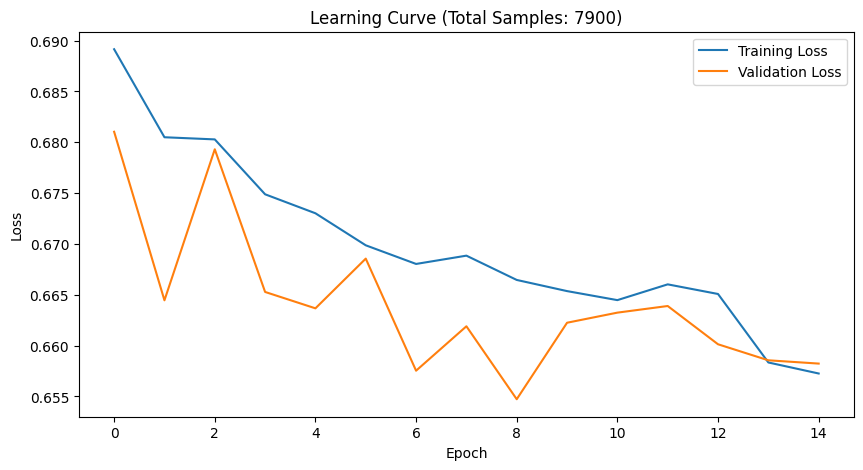

Saving model


100%|██████████| 1/1 [01:48<00:00, 108.21s/it]


Evaluating classifiers
> Evaluating squad_cosine_8k


  0%|          | 0/1 [00:00<?, ?it/s]

Evaluating model trained on squad_cosine_8k dataset on squad dataset
Loading and preprocessing test data
Creating dataset and dataloader
Evaluating model
Plotting confusion matrix
Plotting ROC curve


100%|██████████| 1/1 [00:13<00:00, 13.14s/it]

Evaluation completed. Results saved in the data folder.


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_folder = "model_checkpoints_FINAL_v3_DUO"
method = 'cosine'
save_dir = os.path.join(dir, save_folder)
os.makedirs(save_dir, exist_ok=True)
print(f"Created save directory: {save_dir}")

# Build and train classifiers
classifiers, max_input_len, max_output_len = build_classifiers(
    dataset_paths,
    SimpleNN,
    preprocess_data,
    HallucinationDataset,
    train_model,
    save_dir,
    method,
    sample_size='8k' # 400, 8k, 10k
)

# Evaluate classifiers
evaluate_classifiers(
    classifiers,
    dataset_paths,
    preprocess_data,
    HallucinationDataset,
    evaluate_model,
    save_dir,
    method,
    max_input_len,
    max_output_len
)

In [ ]:
from google.colab import runtime
runtime.unassign()